# Generate Images in the Syle of Monet from Landscape Photos
## Build a CycleGAN with ResNet and U-Net Generators using TensorFlow and Keras

Carolyn Morris \
November 10, 2023

# Overview

The objective of this Kaggle challenge, "I'm Something of a Painter Myself", is to build a Generative Adversarial Network (GAN) that generates 7,000 to 10,000 images in the style of Claude Monet. Monet was a French painter and key figure in introducing a new art movement that became known as Impressionism, a term inspired by his 1874 painting *Impression, Sunrise*. Other well-known Impressionist artists include Auguste Renoir, Camille Pisarro, and Eduoard Manet.

A GAN consists of two neural network models, called the generator and the discriminator. The generator produces an output image, and the discriminator classifies an input image as real or fake (generated). During the training process, the generator learns to produce images that are more likely to be classified as real by the discriminator. The discriminator becomes worse at distinguishing between real and fake.

There are several GAN variations. The variation that is applicable to this project is the CycleGAN, which learns to transform images from one set into images that could belong to another set. For this challenge, the CycleGAN learns to generate an image in the style of a Monet painting from a landscape photo. The two most common architectures for the generator are the U-Net and the Residual Network (ResNet). This notebook includes both.

# Import Libraries

In [1]:
import os
import glob
import time
import shutil
import keras
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import IPython.display as display
from PIL import Image
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE

print('TensorFlow version:', tf.__version__)

D1111 05:09:43.209020596    2898 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1111 05:09:43.209061026    2898 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1111 05:09:43.209064751    2898 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1111 05:09:43.209067424    2898 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1111 05:09:43.209069603    2898 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1111 05:09:43.209071820    2898 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1111 05:09:43.209074024    2898 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D1111 05:09:43.

TensorFlow version: 2.12.0


In [2]:
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
except:
    strategy = tf.distribute.get_strategy()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

In [3]:
print('Number of devices:', strategy.num_replicas_in_sync)

Number of devices: 8


# Load Data

There are two datasets containing 256x256 images stored in TFRecord format. One set contains 300 Monet paintings; the other contains 7,028 landscape photos. TFRecord format is a simple format for storing a sequence of binary records. According to the TensorFlow documentation, the file can only be read sequentially. Each record contains a byte-string, for the data-payload, plus the data-length, and CRC-32C hashes for integrity checking.

In [4]:
# Create lists of file names for both sets of images
filenames_monet = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')
filenames_photos = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')

print('# of Monet files:', len(filenames_monet))
print('# of Photo files:', len(filenames_photos))

# Parse the photos
feature_description = {
    'image_name': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'target': tf.io.FixedLenFeature([], tf.string, default_value='')
}

def parse_function(example_proto):
    return tf.io.parse_single_example(example_proto, feature_description)

parsed_dataset_monet = tf.data.TFRecordDataset(filenames_monet).map(parse_function, num_parallel_calls=AUTOTUNE)
parsed_dataset_photos = tf.data.TFRecordDataset(filenames_photos).map(parse_function, num_parallel_calls=AUTOTUNE)

# of Monet files: 5
# of Photo files: 20


## Visualize the First Three Monet Paintings

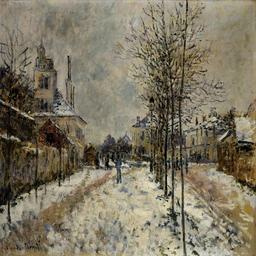

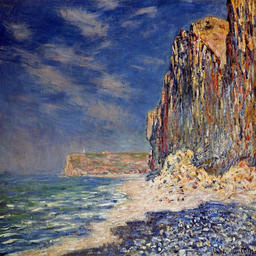

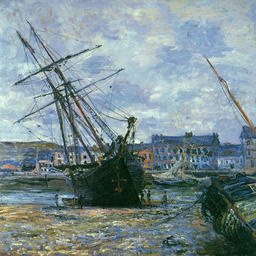

In [5]:
for image_features in parsed_dataset_monet.take(3):
    display.display(display.Image(data = image_features['image'].numpy()))

## Visualize the First Three Photos

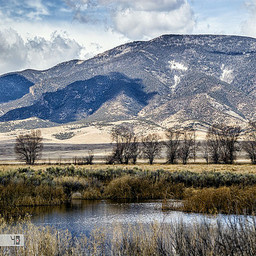

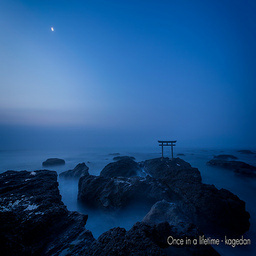

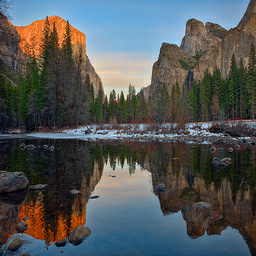

In [6]:
for image_features in parsed_dataset_photos.take(3):
    display.display(display.Image(data = image_features['image'].numpy()))

# Data Preprocessing

In [7]:
IMAGE_SIZE = [256, 256]

# Decode the JPEG-encoded images to uint8 tensors, recast, normalize, and reshape
def decode_image(image):
    img = tf.image.decode_jpeg(image['image'], channels=3)
    img = (tf.cast(img, tf.float32) / 127.5) - 1
    img = tf.reshape(img, [*IMAGE_SIZE, 3])
    return img

dataset_monet = parsed_dataset_monet.map(decode_image, num_parallel_calls=AUTOTUNE)  
dataset_photos = parsed_dataset_photos.map(decode_image, num_parallel_calls=AUTOTUNE)  

## Visualize a sample photo from each decoded set

In [8]:
sample_monet = next(iter(dataset_monet))
sample_photo = next(iter(dataset_photos))

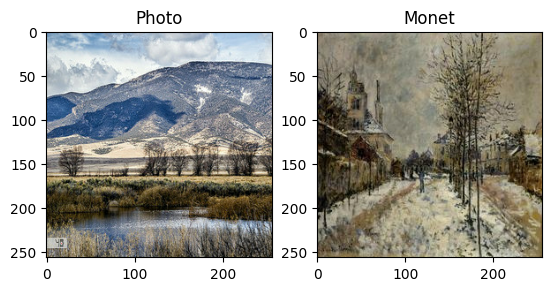

In [9]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(sample_photo * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(sample_monet * 0.5 + 0.5)

plt.show()

## Define additional preprocessing functions

In [10]:
BUFFER_SIZE = 300
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [11]:
def resize(image, height, width):
    image = tf.image.resize(image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return image


def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
    
    return cropped_image


@tf.function()
def random_jitter(image):
    # Resizing to 286 x 286 x 3
    image = resize(image, 286, 286)
    
    # Random cropping to 256 x 256 x 3
    image = random_crop(image)

    # Random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

## Build an Input Pipeline with tf.data

As mentioned in the Load Data section, there are 300 Monet paintings, and 7,028 landscape photos. Since we need at least 7,000 photos to meet the challenge submission requirement, and 300 photos will be used for training to maximize the train set size, I chose to augment the photos test set to avoid training the model on test data.

In [12]:
print('Photos dataset size:', len(list(dataset_photos)))
dataset_photos = dataset_photos.concatenate(dataset_photos)
print('Photos dataset size (augmented):', len(list(dataset_photos)))

Photos dataset size: 7038
Photos dataset size (augmented): 14076


In [13]:
dataset_monet = dataset_monet.map(random_jitter, num_parallel_calls=tf.data.AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_photos = dataset_photos.map(random_jitter, num_parallel_calls=tf.data.AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [14]:
# Split into train and test sets
train_monet = dataset_monet
num_monet = len(list(train_monet))
print('Monet size:', num_monet)

num_photos = len(list(dataset_photos))
print('Photos size:', num_photos)
print()

train_monet = dataset_monet
train_photos = dataset_photos.take(num_monet)
test_photos = dataset_photos.skip(num_monet).take(7000)

print('Train Monet size:', len(list(train_monet)))
print('Train photos size:', len(list(train_photos)))
print('Test photos size:', len(list(test_photos)))

Monet size: 300
Photos size: 14076

Train Monet size: 300
Train photos size: 300
Test photos size: 7000


## Visualize a normal and processed image from both datasets

In [15]:
sample_monet = next(iter(train_monet)) 
sample_photo = next(iter(train_photos))

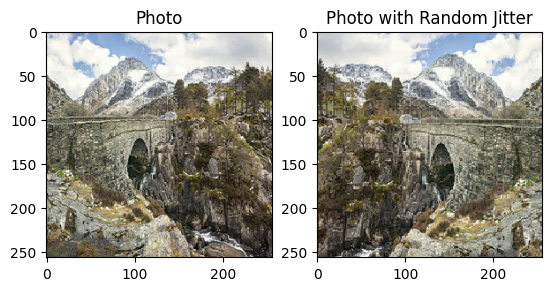

In [16]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(sample_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Photo with Random Jitter')
plt.imshow(random_jitter(sample_photo[0]) * 0.5 + 0.5)

plt.show()

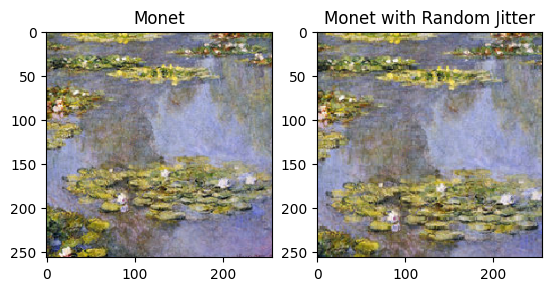

In [17]:
plt.subplot(121)
plt.title('Monet')
plt.imshow(sample_monet[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet with Random Jitter')
plt.imshow(random_jitter(sample_monet[0]) * 0.5 + 0.5)

plt.show()

# Build the Generator

In [18]:
OUTPUT_CHANNELS = 3

In [19]:
def downsample(filters, kernel_size, strides, padding, activation, groups, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters=filters, 
                                      kernel_size=kernel_size, 
                                      strides=strides, 
                                      padding=padding, 
                                      use_bias=False,
                                      kernel_initializer=initializer))

    if apply_instancenorm:
        result.add(tf.keras.layers.GroupNormalization(groups=groups, gamma_initializer=gamma_init))

    result.add(activation)

    return result

In [20]:
def upsample(filters, kernel_size, strides, padding, activation, groups, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, 
                                               kernel_size=kernel_size, 
                                               strides=strides, 
                                               padding=padding,
                                               use_bias=False,
                                               kernel_initializer=initializer))

    result.add(tf.keras.layers.GroupNormalization(groups=groups, gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(activation)

    return result

In [21]:
def residual_block(filters, groups, padding='same', activation=tf.keras.layers.ReLU()):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters=filters, 
                                      kernel_size=3, 
                                      strides=1, 
                                      padding=padding, 
                                      use_bias=False,
                                      kernel_initializer=initializer))
    result.add(tf.keras.layers.GroupNormalization(groups=groups, gamma_initializer=gamma_init))
    result.add(activation)
    
    result.add(tf.keras.layers.Conv2D(filters=filters, 
                                      kernel_size=3, 
                                      strides=1, 
                                      padding=padding, 
                                      use_bias=False,
                                      kernel_initializer=initializer))
    result.add(tf.keras.layers.GroupNormalization(groups=groups, gamma_initializer=gamma_init))
    
    return result

## ResNet Generator

As described in the paper "Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks" by Efros et al., the ResNet generator architecture consists of:
* c7s1-64: a 7×7 Convolution-InstanceNorm-ReLU layer with 64 filters and stride 1
* d128: a 3×3 Convolution-InstanceNorm-ReLU layer with 128 filters and stride 2
* d256: a 3×3 Convolution-InstanceNorm-ReLU layer with 256 filters and stride 2
* R256: a residual block that contains two 3×3 convolutional layers with the same number of filters on both layers
* R256: ""
* R256: ""
* R256: ""
* R256: ""
* R256: ""
* R256: ""
* R256: ""
* R256: ""
* u128: a 3×3 fractional-strided-Convolution-InstanceNorm-ReLU layer with 128 filters and stride 1/2
* u64: a 3×3 fractional-strided-Convolution-InstanceNorm-ReLU layer with 64 filters and stride 1/2
* c7s1-3: a 7×7 Convolution-InstanceNorm-ReLU layer with 3 filters and stride 1

In [22]:
def GeneratorResNet():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
        
    # First convolution
    x = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=7, 
                               strides=1, 
                               padding='same', 
                               kernel_initializer=initializer, 
                               use_bias=False)(inputs)
    x = tf.keras.layers.GroupNormalization(groups=64, gamma_initializer=gamma_init)(x)
    x = tf.keras.layers.ReLU()(x)
    
    # 2 Downsampling
    x = downsample(128, 3, 2, 'same', tf.keras.layers.ReLU(), 128)(x) 
    x = downsample(256, 3, 2, 'same', tf.keras.layers.ReLU(), 256)(x)
    
    # 9 residual blocks
    x = residual_block(256, 256)(x)
    x = residual_block(256, 256)(x)
    x = residual_block(256, 256)(x)
    x = residual_block(256, 256)(x)
    x = residual_block(256, 256)(x)
    x = residual_block(256, 256)(x)
    x = residual_block(256, 256)(x)
    x = residual_block(256, 256)(x)
    x = residual_block(256, 256)(x)

    # 2 Upsampling
    x = upsample(128, 3, 2, 'same', tf.keras.layers.ReLU(), 128, apply_dropout=True)(x) 
    x = upsample(64, 3, 2, 'same', tf.keras.layers.ReLU(), 64, apply_dropout=True)(x)

    # Last convolution, mapping features to RGB
    x = tf.keras.layers.Conv2D(filters=3, 
                               kernel_size=7, 
                               strides=1, 
                               padding='same',
                               activation='tanh')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

## U-Net Generator

In [23]:
def GeneratorUNet():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, 2, 'same', tf.keras.layers.LeakyReLU(), 64, apply_instancenorm=False),  
        downsample(128, 4, 2, 'same', tf.keras.layers.LeakyReLU(), 128),  
        downsample(256, 4, 2, 'same', tf.keras.layers.LeakyReLU(), 256),  
        downsample(512, 4, 2, 'same', tf.keras.layers.LeakyReLU(), 512),  
        downsample(512, 4, 2, 'same', tf.keras.layers.LeakyReLU(), 512),  
        downsample(512, 4, 2, 'same', tf.keras.layers.LeakyReLU(), 512),  
        downsample(512, 4, 2, 'same', tf.keras.layers.LeakyReLU(), 512),  
        downsample(512, 4, 2, 'same', tf.keras.layers.LeakyReLU(), 512)
    ]

    up_stack = [
        upsample(512, 4, 2, 'same', tf.keras.layers.ReLU(), 512, apply_dropout=True), 
        upsample(512, 4, 2, 'same', tf.keras.layers.ReLU(), 512, apply_dropout=True), 
        upsample(512, 4, 2, 'same', tf.keras.layers.ReLU(), 512, apply_dropout=True), 
        upsample(512, 4, 2, 'same', tf.keras.layers.ReLU(), 512),  
        upsample(256, 4, 2, 'same', tf.keras.layers.ReLU(), 256),  
        upsample(128, 4, 2, 'same', tf.keras.layers.ReLU(), 128),  
        upsample(64, 4, 2, 'same', tf.keras.layers.ReLU(), 64)
      ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 
                                           kernel_size=4, 
                                           strides=2, 
                                           padding='same', 
                                           kernel_initializer=initializer, 
                                           activation='tanh')

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

# Build the Discriminator

## Discriminator for ResNet Generator

Again, following the paper by Efros et al. mentioned above, the discriminator architecture is as follows:
* C64: a 4×4 Convolution-InstanceNorm-LeakyReLU layer with 64 filters and stride 2; no InstanceNorm applied
* C128: a 4×4 Convolution-InstanceNorm-LeakyReLU layer with 128 filters and stride 2
* C256: a 4×4 Convolution-InstanceNorm-LeakyReLU layer with 256 filters and stride 2
* C512: a 4×4 Convolution-InstanceNorm-LeakyReLU layer with 512 filters and stride 2
* A convolution to produce a 1-D output

The leaky ReLUs use a slope of 0.2.

In [24]:
def DiscriminatorResNet():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    
    x = downsample(64, 4, 2, 'same', tf.keras.layers.LeakyReLU(0.2), 64, apply_instancenorm=False)(inp) 
    x = downsample(128, 4, 2, 'same', tf.keras.layers.LeakyReLU(0.2), 128)(x)   
    x = downsample(256, 4, 2, 'same', tf.keras.layers.LeakyReLU(0.2), 256)(x)    
    x = downsample(512, 4, 1, 'same', tf.keras.layers.LeakyReLU(0.2), 512)(x)
    
    x = tf.keras.layers.Conv2D(filters=1, 
                               kernel_size=4, 
                               strides=1, 
                               padding='same', 
                               kernel_initializer=initializer,
                               use_bias=False)(x)
    
    return tf.keras.Model(inputs=inp, outputs=x)

## Discriminator for U-Net Generator

In [25]:
def DiscriminatorUNet():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    
    x = downsample(64, 4, 2, 'same', tf.keras.layers.LeakyReLU(), 64, False)(inp)  
    x = downsample(128, 4, 2, 'same', tf.keras.layers.LeakyReLU(), 128)(x)  
    x = downsample(256, 4, 2, 'same', tf.keras.layers.LeakyReLU(), 256)(x)  

    x = tf.keras.layers.ZeroPadding2D()(x)  
    x = tf.keras.layers.Conv2D(filters=512, 
                               kernel_size=4, 
                               strides=1,
                               padding='valid',
                               kernel_initializer=initializer, 
                               use_bias=False)(x)  
    x = tf.keras.layers.GroupNormalization(groups=512, gamma_initializer=gamma_init)(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.ZeroPadding2D()(x)
    x = tf.keras.layers.Conv2D(filters=1, 
                               kernel_size=4, 
                               strides=1, 
                               padding='valid',
                               kernel_initializer=initializer,
                               use_bias=False)(x)

    return tf.keras.Model(inputs=inp, outputs=x)

In [26]:
with strategy.scope():
    generator_g = GeneratorUNet()
    generator_f = GeneratorUNet()
    
    discriminator_x = DiscriminatorUNet()
    discriminator_y = DiscriminatorUNet()

In [27]:
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 128)  131328      ['sequential[0][0]']             
                                                                                              

In [28]:
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 sequential_30 (Sequential)  (None, 128, 128, 64)      3072      
                                                                 
 sequential_31 (Sequential)  (None, 64, 64, 128)       131328    
                                                                 
 sequential_32 (Sequential)  (None, 32, 32, 256)       524800    
                                                                 
 zero_padding2d (ZeroPadding  (None, 34, 34, 256)      0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 31, 31, 512)       2097152   
                                                           

# Define the Loss Functions

## Generator Loss

The generator loss is a sigmoid cross-entropy loss between the real and generated distributions. During training, this should decrease.

In [29]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, 
                                                  reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

## Discriminator Loss

The discriminator loss is the sum of the sigmoid cross-entropy loss of the real images, and the sigmoid cross-entropy loss of the generated images. This penalizes the discriminator for a misclassification.

In [30]:
with strategy.scope():
    def discriminator_loss(disc_real_output, disc_generated_output):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, 
                                                       reduction=tf.keras.losses.Reduction.SUM)(tf.ones_like(disc_real_output), disc_real_output)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, 
                                                            reduction=tf.keras.losses.Reduction.SUM)(tf.zeros_like(disc_generated_output), disc_generated_output)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

## Cycle Consistency Loss

The CycleGAN needs the cycle consistency loss to account for the input image and target image being unpaired.

In [31]:
LAMBDA = 10

In [32]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [33]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))

        return LAMBDA * 0.5 * loss

# Initialize Optimizers

In [34]:
with strategy.scope():
    generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Checkpoints

In [35]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# If a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

# Training

## Visualize sample test image with untrained model

This function is used after the model is trained to generate images in the style of Monet. The untrained model does not generate an image in the style of Monet, as displayed below.

In [36]:
def generate_images(model, test_input, plot):
    prediction = model(test_input)

    if plot:
        plt.figure(figsize=(12, 12))
        
        display_list = [test_input[0], prediction[0]]
        title = ['Input Image', 'Predicted Image']
        
        for i in range(2):
            plt.subplot(1, 2, i+1)
            plt.title(title[i])
            # Getting the pixel values in the [0, 1] range to plot.
            plt.imshow(display_list[i] * 0.5 + 0.5)
            plt.axis('off')
        plt.show()
        
    return prediction[0]

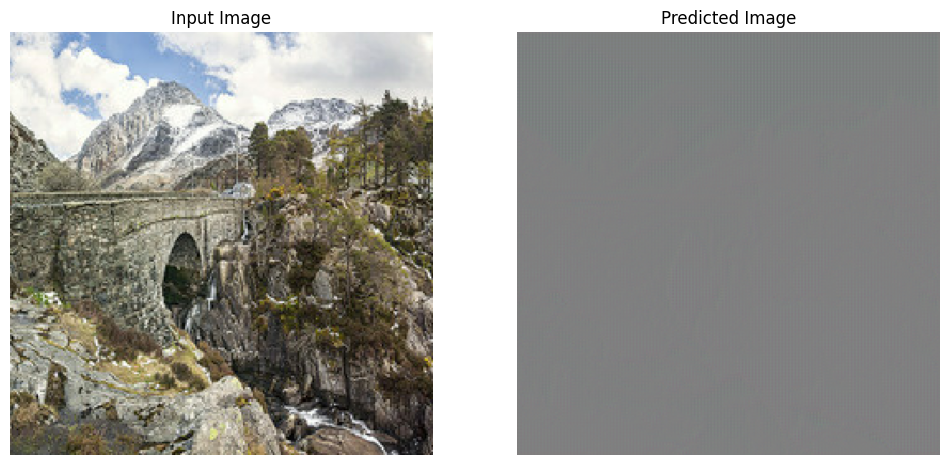

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[ 0.02046371, -0.00311936,  0.00583602],
        [-0.00209044, -0.00897462,  0.02242344],
        [ 0.02761326, -0.00297011,  0.01287521],
        ...,
        [-0.01904623, -0.00287266,  0.01692415],
        [ 0.04457828,  0.00527336,  0.01042404],
        [ 0.00146112, -0.01457463,  0.00810667]],

       [[-0.01331786, -0.00989691,  0.01104199],
        [-0.04531771, -0.01178874, -0.02883622],
        [-0.01284188,  0.00544861,  0.00080223],
        ...,
        [-0.05257713, -0.02617121, -0.03736057],
        [-0.00452905,  0.00238803,  0.00205765],
        [-0.0005721 , -0.00048885, -0.00880854]],

       [[ 0.01597099,  0.01034768,  0.0127974 ],
        [-0.02369152, -0.03199274,  0.01240232],
        [ 0.01262558,  0.02609181,  0.01936544],
        ...,
        [-0.03113812, -0.04419316,  0.00272628],
        [ 0.01510866,  0.03414125,  0.02268749],
        [ 0.00751409, -0.01303138,  0.00794225]],

       ...,

     

In [37]:
generate_images(generator_g, sample_photo, True)

## Create the training loop

There are four main steps:
1. Make predictions
2. Calculate the loss
3. Calculate the gradients using backpropagation
4. Apply the gradients to the optimizer

In [38]:
class CycleGAN(tf.keras.Model):

    def __init__(self, 
                 generator_g, 
                 generator_f, 
                 discriminator_x, 
                 discriminator_y, 
                 lambda_cycle=10):
        super().__init__()
        self.generator_g = generator_g
        self.generator_f = generator_f
        self.discriminator_x = discriminator_x
        self.discriminator_y = discriminator_y
        self.lambda_cycle = lambda_cycle

    def compile(self, 
                generator_g_optimizer, 
                generator_f_optimizer, 
                discriminator_x_optimizer, 
                discriminator_y_optimizer, 
                generator_loss, 
                discriminator_loss, 
                calc_cycle_loss, 
                identity_loss):
        super().compile()
        self.generator_g_optimizer = generator_g_optimizer
        self.generator_f_optimizer = generator_f_optimizer
        self.discriminator_x_optimizer = discriminator_x_optimizer
        self.discriminator_y_optimizer = discriminator_y_optimizer
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss
        self.calc_cycle_loss = calc_cycle_loss
        self.identity_loss = identity_loss
    
    def train_step(self, dataset):
        real_x, real_y = dataset
        
        # Persistent is set to True because the tape is used more than once to calculate the gradients.
        with tf.GradientTape(persistent=True) as tape:
            # Generator G translates X -> Y (photo -> Monet)
            # Generator F translates Y -> X (Monet -> photo)

            fake_y = self.generator_g(real_x, training=True)
            cycled_x = self.generator_f(fake_y, training=True)

            fake_x = self.generator_f(real_y, training=True)
            cycled_y = self.generator_g(fake_x, training=True)

            # same_x and same_y are used for identity loss
            same_x = self.generator_f(real_x, training=True)
            same_y = self.generator_g(real_y, training=True)

            disc_real_x = self.discriminator_x(real_x, training=True)
            disc_real_y = self.discriminator_y(real_y, training=True)

            disc_fake_x = self.discriminator_x(fake_x, training=True)
            disc_fake_y = self.discriminator_y(fake_y, training=True)

            # Calculate the loss
            # Generator adversarial loss
            gen_g_loss = self.generator_loss(disc_fake_y)
            gen_f_loss = self.generator_loss(disc_fake_x)
            
            # Cycle loss
            total_cycle_loss = self.calc_cycle_loss(real_x, cycled_x, self.lambda_cycle) + self.calc_cycle_loss(real_y, cycled_y, self.lambda_cycle)

            # Total generator loss = adversarial loss + cycle loss
            total_gen_g_loss = gen_g_loss + total_cycle_loss + self.identity_loss(real_y, same_y, self.lambda_cycle)
            total_gen_f_loss = gen_f_loss + total_cycle_loss + self.identity_loss(real_x, same_x, self.lambda_cycle)

            # Discriminator loss
            disc_x_loss = self.discriminator_loss(disc_real_x, disc_fake_x)
            disc_y_loss = self.discriminator_loss(disc_real_y, disc_fake_y)

        # Calculate the gradients for generator and discriminator
        generator_g_gradients = tape.gradient(total_gen_g_loss, self.generator_g.trainable_variables)
        generator_f_gradients = tape.gradient(total_gen_f_loss, self.generator_f.trainable_variables)

        discriminator_x_gradients = tape.gradient(disc_x_loss, self.discriminator_x.trainable_variables)
        discriminator_y_gradients = tape.gradient(disc_y_loss, self.discriminator_y.trainable_variables)

        # Apply the gradients to the optimizer
        self.generator_g_optimizer.apply_gradients(zip(generator_g_gradients, self.generator_g.trainable_variables))
        self.generator_f_optimizer.apply_gradients(zip(generator_f_gradients, self.generator_f.trainable_variables))

        self.discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, self.discriminator_x.trainable_variables))
        self.discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, self.discriminator_y.trainable_variables))
        
        return {
            'gen_g_loss' : total_gen_g_loss,
            'gen_f_loss' : total_gen_f_loss,
            'disc_x_loss' : disc_x_loss,
            'disc_y_loss' : disc_y_loss
        }

In [39]:
with strategy.scope():
    model = CycleGAN(
        generator_g = generator_g,
        generator_f = generator_f,
        discriminator_x = discriminator_x,
        discriminator_y = discriminator_y
    )
    
    model.compile(
        generator_g_optimizer = generator_g_optimizer,
        generator_f_optimizer = generator_f_optimizer,
        discriminator_x_optimizer = discriminator_x_optimizer,
        discriminator_y_optimizer = discriminator_y_optimizer,
        generator_loss = generator_loss,
        discriminator_loss = discriminator_loss,
        calc_cycle_loss = calc_cycle_loss,
        identity_loss = identity_loss
    )

In [40]:
model.fit(
    tf.data.Dataset.zip((train_photos, train_monet)), 
    epochs=20
)

Epoch 1/20


2023-11-11 05:14:39.999958: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-11-11 05:14:41.675512: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


300/300 [==============================] - 158s 131ms/step - gen_g_loss: 5.2081 - gen_f_loss: 5.3051 - disc_x_loss: 560.6608 - disc_y_loss: 577.4573
Epoch 2/20
300/300 [==============================] - 39s 129ms/step - gen_g_loss: 3.6426 - gen_f_loss: 3.6795 - disc_x_loss: 590.3463 - disc_y_loss: 587.1974
Epoch 3/20
300/300 [==============================] - 39s 130ms/step - gen_g_loss: 3.5081 - gen_f_loss: 3.5453 - disc_x_loss: 580.9615 - disc_y_loss: 580.3205
Epoch 4/20
300/300 [==============================] - 39s 129ms/step - gen_g_loss: 3.3831 - gen_f_loss: 3.4411 - disc_x_loss: 562.9564 - disc_y_loss: 566.4183
Epoch 5/20
300/300 [==============================] - 39s 128ms/step - gen_g_loss: 3.2170 - gen_f_loss: 3.2496 - disc_x_loss: 557.1812 - disc_y_loss: 560.5607
Epoch 6/20
300/300 [==============================] - 39s 128ms/step - gen_g_loss: 3.0954 - gen_f_loss: 3.1580 - disc_x_loss: 561.0813 - disc_y_loss: 570.0070
Epoch 7/20
300/300 [==============================] - 39

# Generate Images from Test Data

## Visualize the first 5 generated images from the test dataset

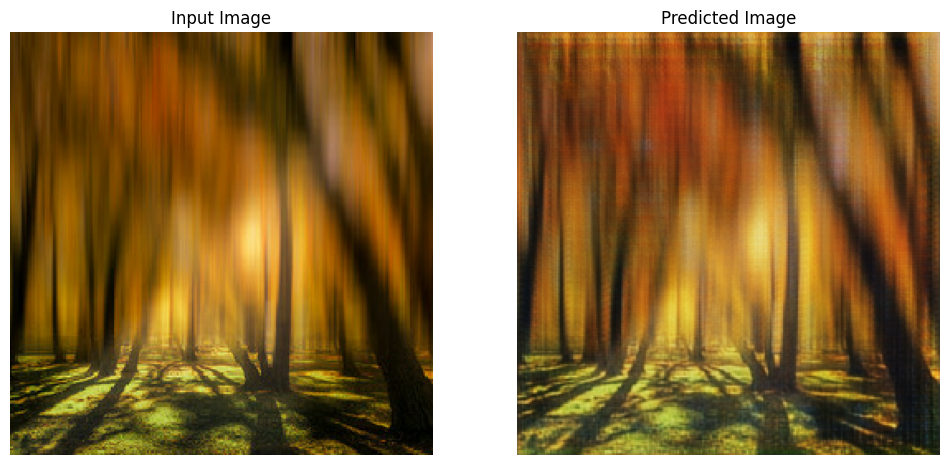

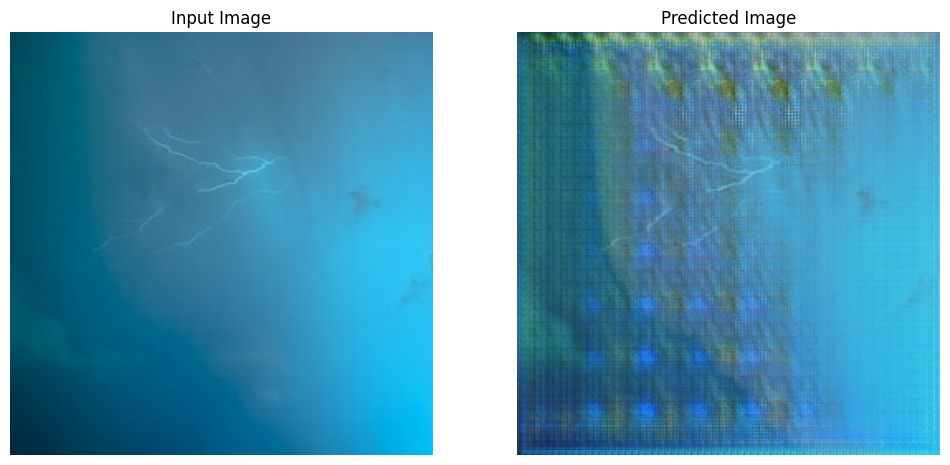

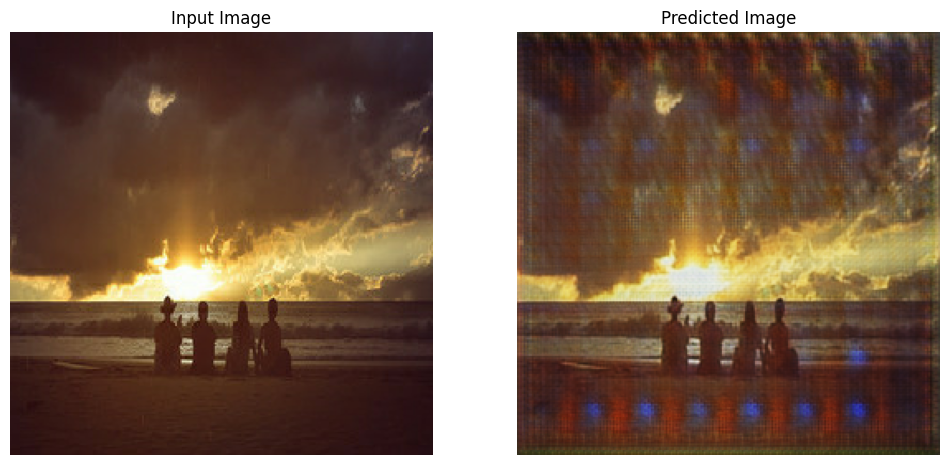

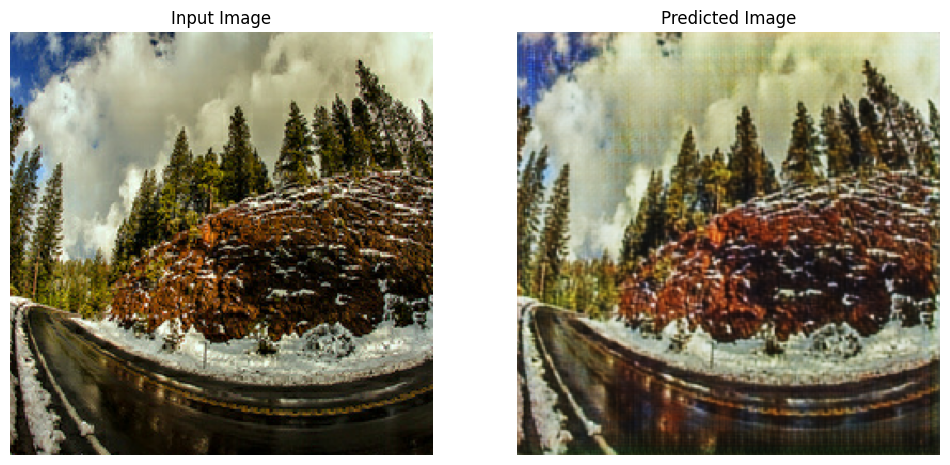

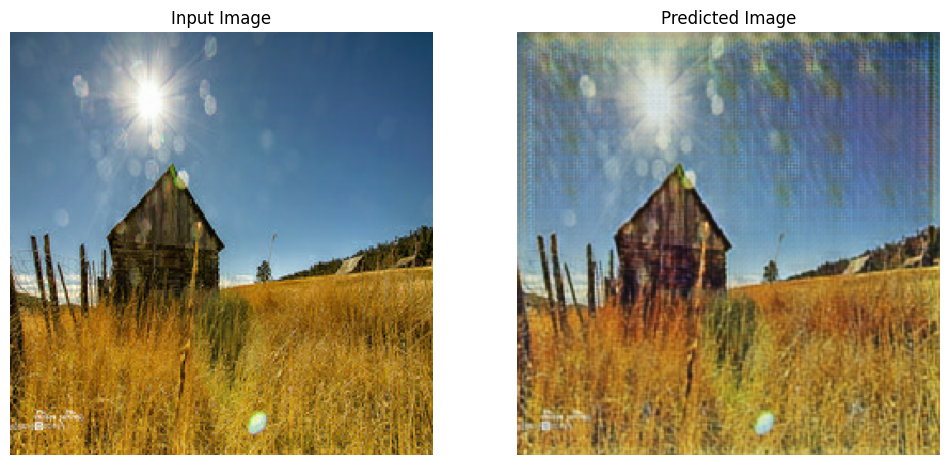

In [41]:
for inp in test_photos.take(5):
    generate_images(generator_g, inp, True)

## Apply CycleGAN to generate images in the style of Monet from 7,000 test photos

In [ ]:
os.mkdir('/kaggle/images/')

c = 1
for inp in test_photos:
    if c % 100 == 0:
        print(c)
    im = generate_images(generator_g, inp, False).numpy()
    im = Image.fromarray((im * 127.5 + 127.5).astype(np.uint8))
    im = im.save('/kaggle/images/generated_img_{}.jpg'.format(c))
    c += 1

## Export images to a zip directory

In [ ]:
shutil.make_archive('/kaggle/working/images', 'zip', '/kaggle/images')

# Performance Summary

The table below summarizes the performance of the two different CycleGAN architectures. The submissions were evaluated with the MiFID (Memorization-informed Fréchet Inception Distance), for which a lower score is better. The U-Net generator architecture achieved better results in the 3-hour (10,800-second) runtime limit.

| Model      | Epochs      | Time (s)    | MiFID         |
| :---       | :---        | :---        | :---          |
| U-Net      | 200         | 10499.2     | 42.42375      |
| ResNet     | 75          | 10317.0     | 86.75305      |